In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import seaborn as sns
from matplotlib import pyplot as plt
import pickle

In [2]:
# Load datasets
df_true = pd.read_csv("./data/NEWS/True.csv")
df_fake = pd.read_csv("./data/NEWS/Fake.csv")

In [3]:
df_true["label"] = 1
df_fake["label"] = 0
df = pd.concat([df_fake, df_true])
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df.text = df.title+df.text
df.drop(columns=["title", "subject", "date"], axis = 1, inplace=True)

In [5]:
X = df["text"]
Y = df["label"]
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=7)

In [6]:
print(len(x_train), len(x_test), len(y_train), len(y_test))

35918 8980 35918 8980


### Get word embeddings using BERT model

In [7]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [8]:
bert_preprocess_model = hub.KerasLayer(preprocess_url, name='preprocessing')
bert_encoder_model = hub.KerasLayer(encoder_url, name='BERT_encoder')

In [12]:
# # Save the encoder and preprocessor model
# bert_encoder_save_file = "./saved_models/bert_encoder.pkl"
# bert_preprocess_model_save_file = "./saved_models/bert_preprocess.pkl"


In [9]:
def getSentenceEmbddings(dataframe_series):
    '''Generate sentence embeddings for a given pandas series of text data using BERT model.'''''
    preprocessed_text = bert_preprocess_model(dataframe_series)
    return bert_encoder_model(preprocessed_text)['pooled_output']

### Define the BERT model

In [10]:
def buildClassifierModel():
    # BERT layers 
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    outputs = bert_encoder_model(encoder_inputs)

    # Neural network layers
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [11]:
classifier_model = buildClassifierModel()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

### Training the BERT model

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy(name='accuracy')

In [13]:
epochs =5
steps_per_epoch = len(x_train)/10
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [14]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
classifier_model.fit(x_train, y_train, epochs)

7184/7184 [==============================] - 10268s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000


In [16]:
# save model
classifier_model.save("./saved_models/bert/bert_classifier", include_optimizer=False)

INFO:tensorflow:Assets written to: ./saved_models/bert/bert_classifier\assets


INFO:tensorflow:Assets written to: ./saved_models/bert/bert_classifier\assets


In [29]:
# load the saved model
bert_fit_model = tf.saved_model.load("./saved_models/bert_classifier")

OSError: SavedModel file does not exist at: ./saved_models/bert_classifier\{saved_model.pbtxt|saved_model.pb}

In [17]:
loss, accuracy = classifier_model.evaluate(x_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

183/281 [==================>...........] - ETA: 14:37 - loss: 0.0000e+00 - accuracy: 1.0000

In [37]:
y_predicted = tf.sigmoid(bert_fit_model(tf.constant(x_test)))
print(y_predicted)

281/281 [==============================] - 1993s 7s/step


In [55]:
cm = confusion_matrix(y_test, y_predicted)
cm 


ValueError: Found input variables with inconsistent numbers of samples: [16158, 8980]

Text(50.722222222222214, 0.5, 'Truth')

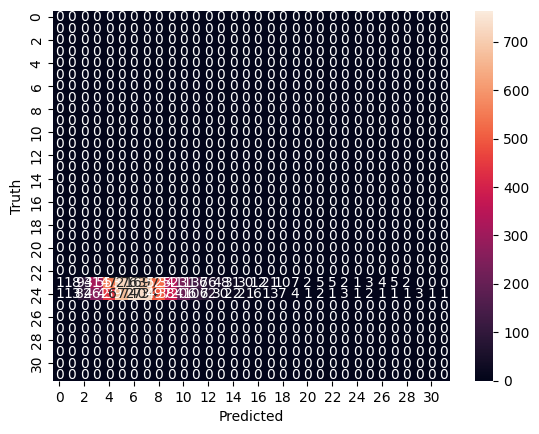

In [43]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [56]:
print(classification_report(y_test, y_predicted))

ValueError: Found input variables with inconsistent numbers of samples: [16158, 8980]

#### Save the model